# Barley Yield in Germany

## Introduction
The objective of this project is to develop a predictive regression model for barley yield in Germany using climate data spanning from 1990 to 2009. The dataset includes variables related to weather conditions such as precipitation, sun hours, temperature, vapor pressure, and wind velocity. The aim is to select three climate variables that significantly influence barley yield, build a regression model using these variables, and evaluate the model's performance.

## Exploratory Data Analysis

To understand the dataset, we first examine a description of each column, familiarizing ourselves with the variables:

* yield_dt_ha = Barley yield in dt/ha
* prec = precipitation sum in mm
* sun_hours = average of daily sun hours in h
* temp_max = average of daily maximum temperature at 2 m height in °C
* temp_min = average of daily minimum temperature at 2 m height in °C
* temp_min_ground = average of daily minimum temperature at 5 cm height in °C
* vap_pressure = average of daily mean vapour pressure in hPa
* wind_vel = average of daily mean wind speed in m/s

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

def load_data():
    # Read the file into a DataFrame
    yield_df = pd.read_csv("/usr/local/repositories/projects/barley_yield_prediction/data/barley_yield.txt", sep="\s+")
    yield_df.columns = ["year", "yield_dt_ha"]
    preds_df = pd.read_csv("/usr/local/repositories/projects/barley_yield_prediction/data/climate_variables.txt", sep="\s+")
    # Merge
    data_df = pd.merge(yield_df, preds_df, on="year")
    return data_df


data_df = load_data()
data_df.describe()

,year,yield_dt_ha,prec,sun_hours,temp_max,temp_min,temp_min_ground,vap_pressure,wind_vel
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,1999.50000,57.295000,636.915000,4.216582,13.777801,5.004618,3.485530,9.798385,3.013229
std,5.91608,4.611139,116.634378,0.418256,0.726581,0.733260,0.788040,0.375083,0.506400
min,1990.00000,50.000000,456.500000,3.496944,11.325956,3.115027,1.908470,8.974590,1.826479
25%,1994.75000,54.050000,574.525000,4.073596,13.402522,4.585959,2.897877,9.652117,3.025833
50%,1999.50000,57.300000,614.650000,4.151458,13.831096,4.958904,3.507912,9.864521,3.164247
75%,2004.25000,59.825000,688.125000,4.316096,14.304247,5.513562,4.109384,10.056370,3.289658
max,2009.00000,65.600000,891.500000,5.335068,14.602740,6.230411,4.634615,10.376776,3.532055


# Correlation Analysis
The correlation matrix reveals that the correlation between the predictors and the yield variable is generally weak, with the highest absolute correlation being 0.34. The most correlated variable with yield is wind velocity, followed by vapor pressure. Surprisingly, precipitation is the second least correlated variable, which may suggest that barley does not suffer from water deficiency in this region, or that annual precipitation does not accurately reflect the water availability during the critical periods of the crop growth cycle.

# Multicollinearity
The analysis also shows strong correlations between some predictor variables, indicating potential multicollinearity issues:
* Air and ground temperatures (correlation: 0.93)
* Wind velocity and vapor pressure (correlation: 0.58)

# Scatterplots and Outlier Detection
Scatterplots are utilized to detect any non-linear relationships between yield and the predictors, which may not be captured well by linear correlation. Additionally, they help in identifying outliers. In this case, scatterplots confirm the results of the correlation matrix, showing weak associations between yield and the predictors. There do not appear to be significant non-linear relationships in the data.

The dataset does not exhibit clear outliers, which is understandable given that all variables are yearly aggregates for the entire nation. This aggregation tends to smooth out any extreme values that might otherwise appear in more granular or localized datasets.

Text(0.5, 1.0, 'Correlation Heatmap')

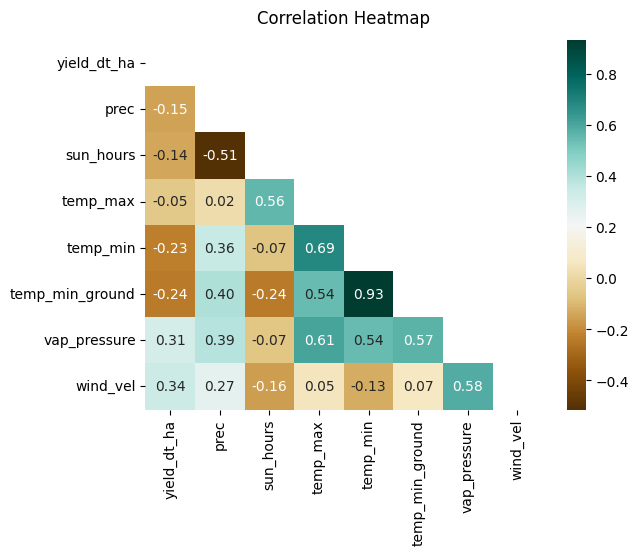

In [2]:
# --------------------------------------------------------------
# Plot Correlation Matrix Heatmap
# --------------------------------------------------------------
# Basic Seaborn Heatmap
correlation_df = data_df.drop("year", axis=1).corr()
# # plt.figure(figsize=(20, 12))
# p = sns.heatmap(correlation_matrix, annot=True, cmap="BrBG", fmt=".2f")
# p.set_title("Correlation Heatmap", fontdict={"fontsize": 12}, pad=12)
# plt.savefig("../figures/heatmap.png", dpi=300, bbox_inches="tight")

# Triangle Correlation Heatmap
# plt.figure(figsize=(20, 12))
mask = np.triu(np.ones_like(correlation_df))
p = sns.heatmap(correlation_df, mask=mask, annot=True, cmap="BrBG", fmt=".2f")
p.set_title("Correlation Heatmap", fontdict={"fontsize": 12}, pad=12)

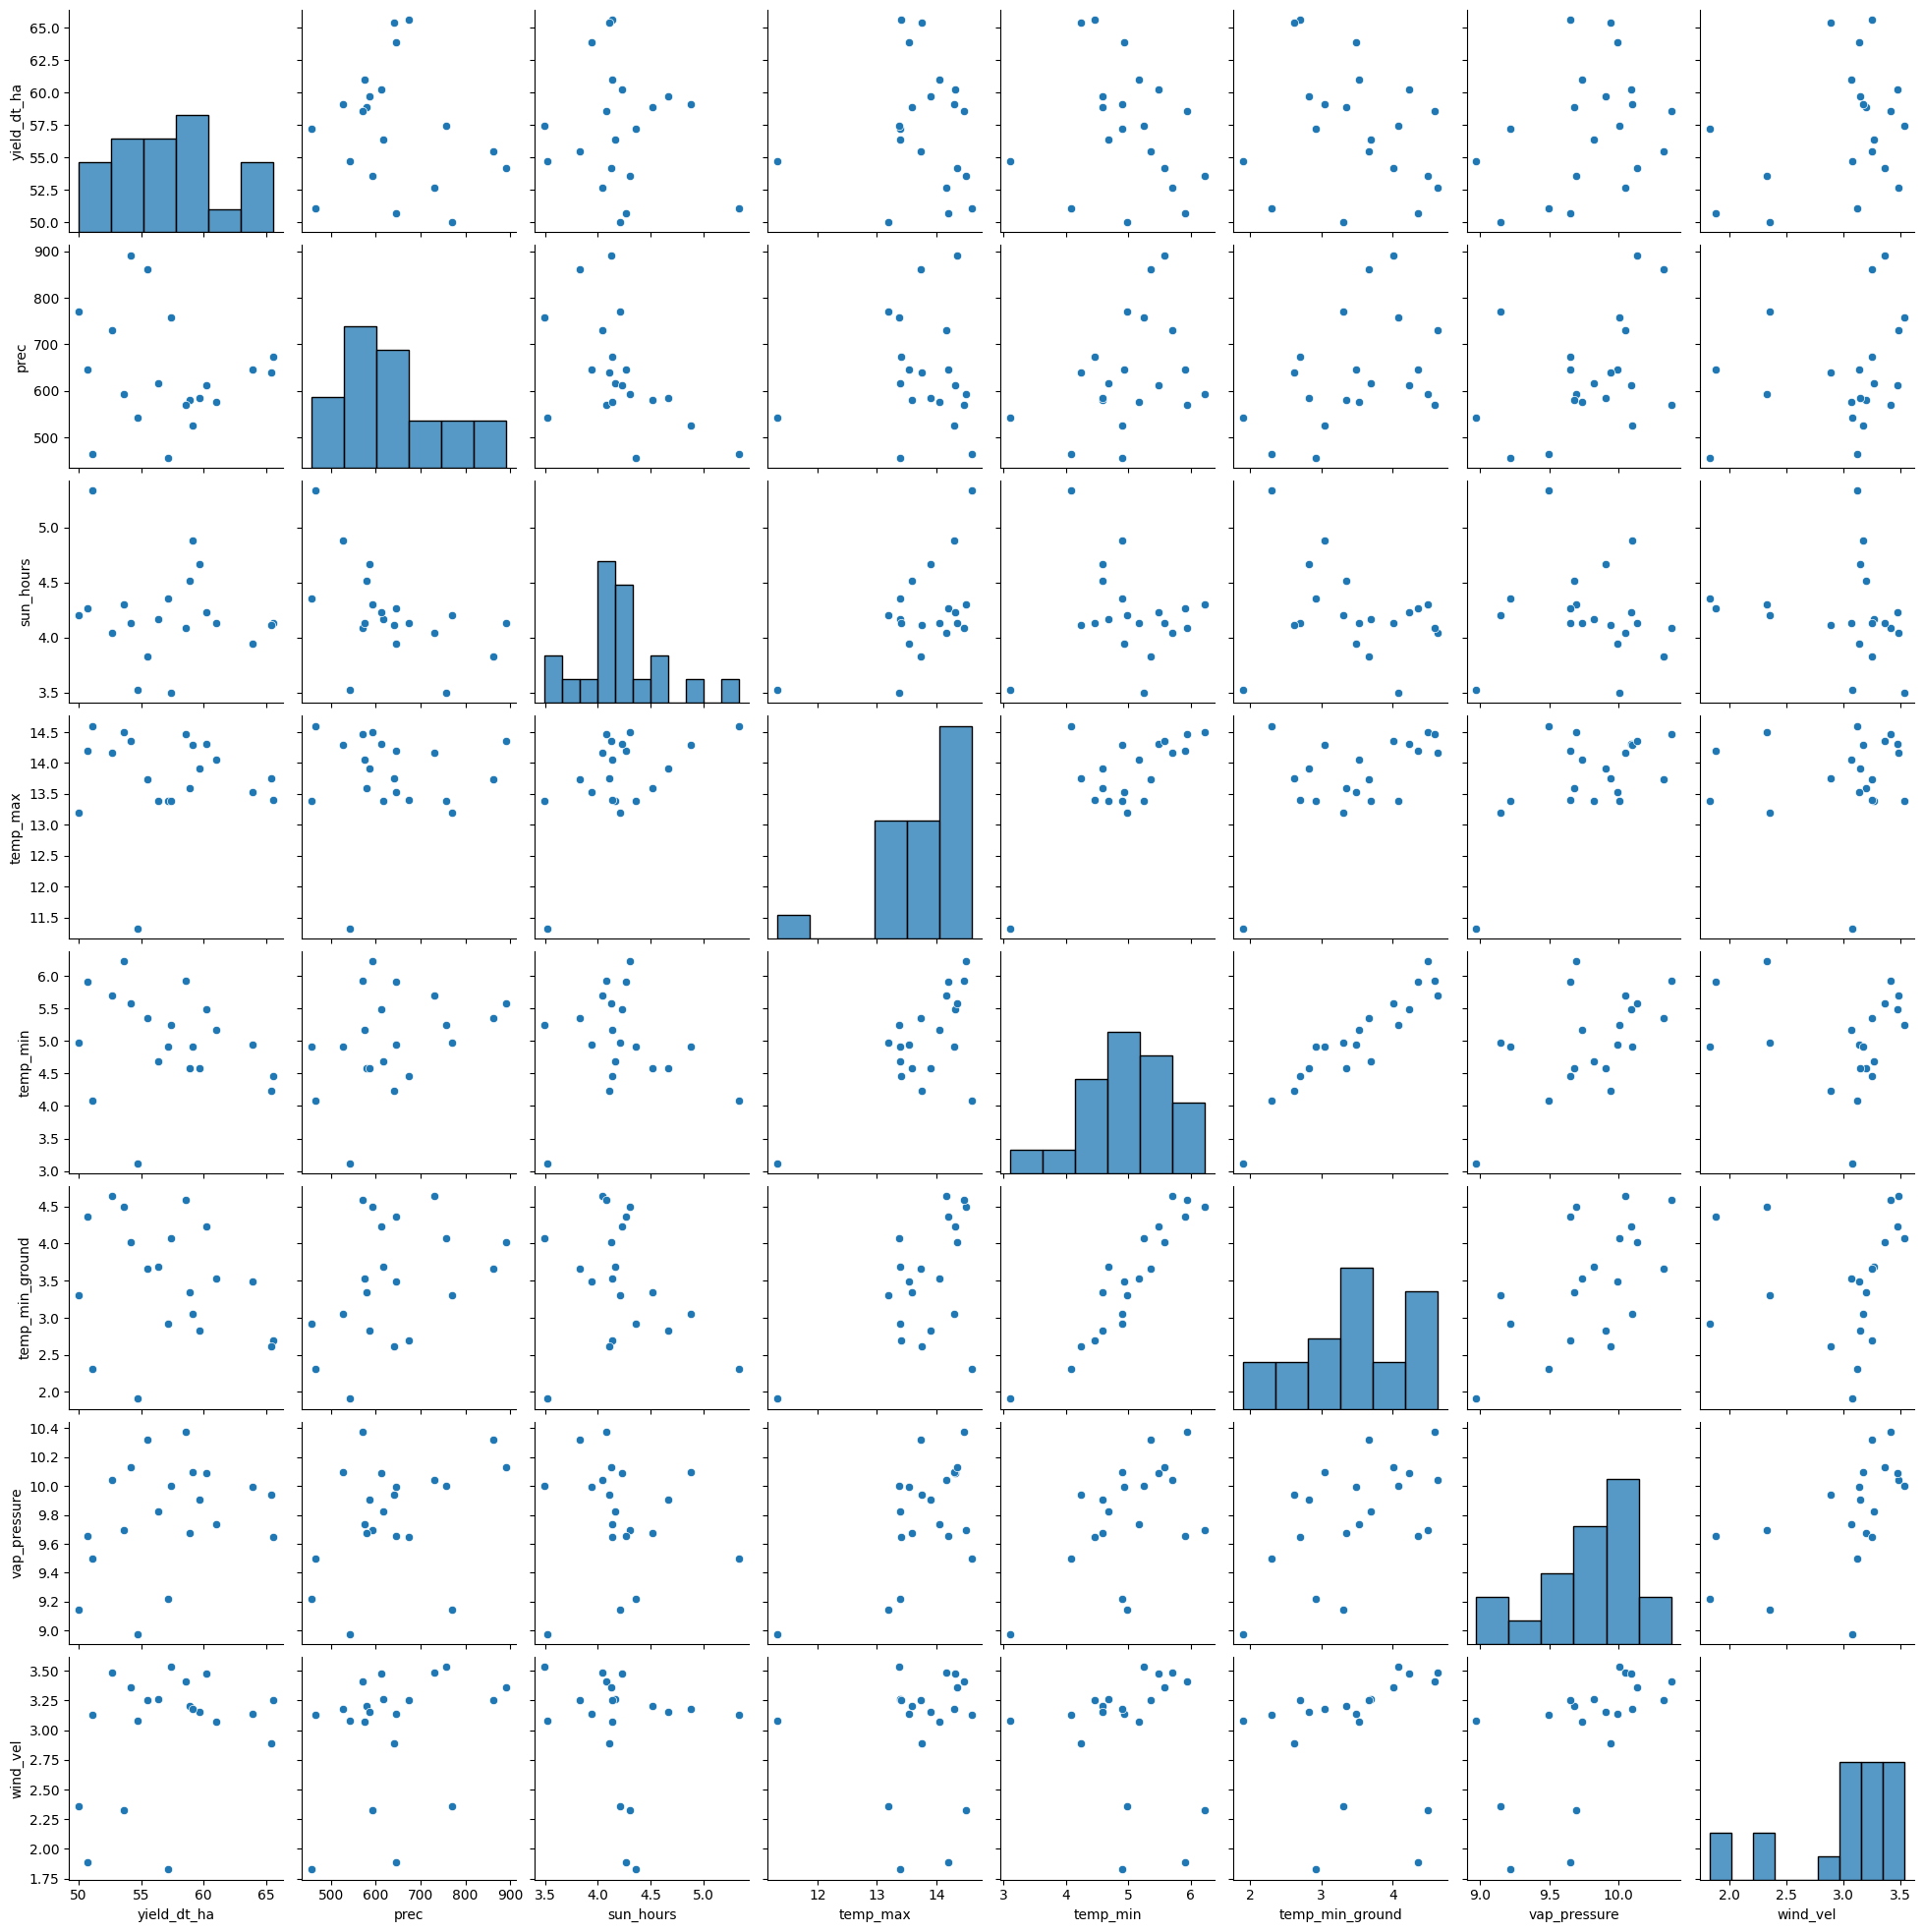

In [3]:
sns.pairplot(data_df.drop("year", axis=1))

# Forward Selection

First Loop:

The variable with the lowest p-value is wind velocity. However, its p-value is still high, indicating that it is not statistically significant.

Second Loop:

Despite the first loop not revealing any significant variables, we proceed by selecting wind velocity as the first variable and attempt to add a second variable. Unfortunately, none of the potential second variables are statistically significant either. 
This illustrates a symptom of multicollinearity. When adding vapor pressure, the parameter for wind velocity changes (from 3.07 to 2.14). This occurs because these two variables are highly correlated, and adding one to the model affects the significance of the other.

Conclusion:

None of the variables shows a strong relationship with yields. Several factors may contribute to this:

* Low Number of Observations: There are only 19 observations, which is a small sample size for achieving statistical significance in parameter testing.

* Annual Aggregation: The weather variables are aggregated annually, which might weaken the relationship between the variables and barley yields. Aggregating the data over the cropping season, or better yet, during specific stages of the crop cycle, could provide a more accurate adjustment.

* Geographic Aggregation: Similarly, the lack of spatial granularity may affect the results. Aggregating variables specifically for areas where barley is planted could improve the model's accuracy.

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
(candidate) = ("vap_pressure")

def check_constant(X, y):
    X2 = sm.add_constant(X)
    y = data_df[target]
    model = sm.OLS(y, X2).fit()
    pvalues = model.pvalues
    return pvalues['const'] < 0.1



def evaluate_new_predictors(data_df, target, predictors, selected_vars=[]):
    # Initialize list to store results
    results = []

    # Loop over each predictor
    for candidate in predictors:
        if candidate not in selected_vars:
            # Create model with selected variables and the candidate variable
            model_vars = selected_vars + [candidate]
            X = data_df[model_vars]
            y = data_df[target]
            add_contant = check_constant(X, y)

            # if add_contant:
            #     X = sm.add_constant(data_df[model_vars])
            
            model = sm.OLS(y, X).fit()
            model.summary()
            y_hat = model.predict(X)
            
            # Collect parameters and p-values
            params = model.params
            pvalues = model.pvalues
            # Calculate R-squared and RMSE
            r_squared = model.rsquared
            rmse = np.sqrt(mean_squared_error(y, y_hat))
            result = {
                'predictor': candidate,
                'const': add_contant,
                'params': params[candidate],
                'pvalues': pvalues[candidate],
                'r_squared': r_squared,
                'rmse': rmse,
            }
            # Include already selected variables' parameters and p-values
            for var in selected_vars:
                result[f'param_{var}'] = params[var]
                result[f'pvalue_{var}'] = pvalues[var]
            
            results.append(result)

            ggplot(data_df)+ geom_point(aes(y=target, x=candidate))
            ggplot(data_df)+ geom_point(aes(y=target, x=y_hat))
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    results_df.sort_values("pvalues", ascending=True, inplace=True)
    return results_df

# First Loop
# Define the target and predictor variables
target = 'yield_dt_ha'
predictors = ['prec', 'sun_hours', 'temp_max', 'temp_min', 'temp_min_ground', 'vap_pressure', 'wind_vel']
selected_vars = []  # Start with no selected variables or add any pre-selected variables here

# Evaluate new predictors
results_df = evaluate_new_predictors(data_df, target, predictors, selected_vars)
display(results_df)

: 

In [ ]:
# Second Loop
target = 'yield_dt_ha'
predictors = ['prec', 'sun_hours', 'temp_max', 'temp_min', 'temp_min_ground', 'wind_vel', ]
selected_vars = ['vap_pressure']  # Start with no selected variables or add any pre-selected variables here

# Evaluate new predictors
results_df = evaluate_new_predictors(data_df, target, predictors, selected_vars)
display(results_df)

In [ ]:
# Third Loop
target = 'yield_dt_ha'
predictors = ['prec', 'sun_hours', 'temp_max', 'temp_min', 'vap_pressure', ]
selected_vars = ['vap_pressure', "temp_min_ground"]  # Start with no selected variables or add any pre-selected variables here

# Evaluate new predictors
results_df = evaluate_new_predictors(data_df, target, predictors, selected_vars)
display(results_df)

# Focus on Prediction Ability

From a statistical perspective, we aim to determine whether a parameter is significantly different from zero to ascertain if it genuinely influences yields. From a prediction standpoint, we focus on maximizing  prediction metrics, such as mean squared error (MSE), R² and RMSE. In this approach, we will select the set of parameters that optimize prediction performance using cross-validation techniques. While the individual parameters may not always be statistically significant, and we shouldn't make any claims about the individual effect of the parameters on the predicted variable. 

The cross-validation process splits the data into folds and evaluates the model's performance on each fold, ensuring that the selected predictors generalize well to unseen data.

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# https://medium.com/@kelvinsang97/feature-selection-stepwise-regression-forward-selection-and-backward-elimination-with-python-d53230be995c
target = 'yield_dt_ha'
predictors = ['prec', 'sun_hours', 'temp_max', 'temp_min', 'temp_min_ground', 'vap_pressure', 'wind_vel']

y = data_df[target]
X = data_df[predictors]

linearreg = LinearRegression()


# Initialize linear regression model
linearreg = LinearRegression()

# Forward selection with cross-validation
forward = SFS(estimator=linearreg,
              k_features=3,
              forward=True,
              floating=False,
              verbose=False,
              scoring="neg_mean_squared_error",)

sf = forward.fit(X,y)

feat_names = list(sf.k_feature_names_)
print(feat_names)

print(sf.k_feature_idx_)

X_opt = sm.add_constant(data_df[feat_names])
regressor_OLS = sm.OLS(endog=y,exog=X_opt).fit()
regressor_OLS.summary()

: 

In [ ]:
feat_names = ['temp_min', 'vap_pressure']
X_opt = data_df[feat_names]

regressor_OLS = sm.OLS(endog=y,exog=X_opt).fit()
regressor_OLS.summary()